In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import requests
import math 
from math import floor
from scipy.stats.mstats import winsorize
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from keras.models import Sequential 
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
df = pd.read_csv("file2.csv")

In [3]:
df.head()

,Date,ETH,BTC,XRP,LTC,XLM,Palladium,Gold,HSI,N225,SP500,NVIDIA,AMD
0,2016-01-02,-0.011498,-0.002049,0.018472,-0.002849,-0.004005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2016-01-03,0.037115,-0.007913,-0.007914,-0.005714,0.001723,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2016-01-04,-0.017929,0.007163,-0.009806,0.005747,0.002294,-0.023911,0.008379,-0.015704,-0.015203,-0.012430,-0.017900,-0.034843
3,2016-01-05,-0.004509,-0.002609,0.014434,-0.008571,-0.015446,-0.015527,0.002976,-0.006489,-0.004172,0.001294,0.016064,-0.007220
4,2016-01-06,0.000720,-0.006598,-0.006784,-0.005764,-0.028472,-0.023911,0.008379,-0.009812,-0.009942,-0.012430,-0.036179,-0.044248


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1826 non-null   object 
 1   ETH        1826 non-null   float64
 2   BTC        1826 non-null   float64
 3   XRP        1826 non-null   float64
 4   LTC        1826 non-null   float64
 5   XLM        1826 non-null   float64
 6   Palladium  1826 non-null   float64
 7   Gold       1826 non-null   float64
 8   HSI        1826 non-null   float64
 9   N225       1826 non-null   float64
 10  SP500      1826 non-null   float64
 11  NVIDIA     1826 non-null   float64
 12  AMD        1826 non-null   float64
dtypes: float64(12), object(1)
memory usage: 185.6+ KB


In [5]:
df['Date'] = pd.to_datetime(df['Date'],format = "%Y-%m-%d")

In [6]:
df.set_index('Date', inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2016-01-02 to 2020-12-31
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ETH        1826 non-null   float64
 1   BTC        1826 non-null   float64
 2   XRP        1826 non-null   float64
 3   LTC        1826 non-null   float64
 4   XLM        1826 non-null   float64
 5   Palladium  1826 non-null   float64
 6   Gold       1826 non-null   float64
 7   HSI        1826 non-null   float64
 8   N225       1826 non-null   float64
 9   SP500      1826 non-null   float64
 10  NVIDIA     1826 non-null   float64
 11  AMD        1826 non-null   float64
dtypes: float64(12)
memory usage: 185.5 KB


In [8]:
df.head(3)

,ETH,BTC,XRP,LTC,XLM,Palladium,Gold,HSI,N225,SP500,NVIDIA,AMD
Date,,,,,,,,,,,,
2016-01-02,-0.011498,-0.002049,0.018472,-0.002849,-0.004005,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000
2016-01-03,0.037115,-0.007913,-0.007914,-0.005714,0.001723,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000
2016-01-04,-0.017929,0.007163,-0.009806,0.005747,0.002294,-0.023911,0.008379,-0.015704,-0.015203,-0.01243,-0.0179,-0.034843


## Model

Puoi scegliere fino a quando guardare in avanti con la previsione

In [9]:
nrows = df.shape[0]
np_data = np.reshape(np.array(df), (nrows, -1))

In [10]:
# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data = scaler.fit_transform(np_data)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(df['BTC'])
np_BTC_scaled = scaler_pred.fit_transform(df_Close)

In [11]:
type(np_data)

numpy.ndarray

In [12]:
np_data.shape

(1826, 12)

In [13]:
np_data[0]

array([0.45604965, 0.55802666, 0.72273617, 0.54557888, 0.53423237,
       0.55361367, 0.57788437, 0.5929632 , 0.59024655, 0.58908631,
       0.58135872, 0.56380863])

In [14]:
type(np_data)

numpy.ndarray

In [15]:
index = df.columns.get_loc("BTC")
index

1

In [16]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 1 # = number of neurons in the first layer of the neural network

# Prediction Index

index_Close = index

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data.shape[0] * 0.9)

# Create the training and test data
train_data = np_data[0:train_data_len, :]
test_data = np_data[train_data_len - sequence_length:, :]

In [17]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
              break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end,index_Close]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)
n_past = 50
n_future = 1


In [18]:
# Generate training data and test data
x_train, y_train = split_series(train_data,n_past, n_future)
x_test, y_test = split_series(test_data,n_past, n_future)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][n_past-1][index_Close])
print(y_train[0])

(1594, 50, 12) (1594, 1)
(133, 50, 12) (133, 1)
0.6138494607760079
[0.61384946]


In [19]:
x_train[0:6]

array([[[0.45604965, 0.55802666, 0.72273617, ..., 0.58908631,
         0.58135872, 0.56380863],
        [0.78387126, 0.50159099, 0.5170577 , ..., 0.58908631,
         0.58135872, 0.56380863],
        [0.4126808 , 0.64667686, 0.50231521, ..., 0.        ,
         0.29371463, 0.11983389],
        ...,
        [1.        , 0.7175976 , 0.44177706, ..., 0.43873116,
         1.        , 0.63087219],
        [1.        , 0.54174678, 0.82249332, ..., 0.53715996,
         0.79532764, 0.56380863],
        [0.        , 0.95213346, 0.58631226, ..., 0.58908631,
         0.58135872, 0.56380863]],

       [[0.78387126, 0.50159099, 0.5170577 , ..., 0.58908631,
         0.58135872, 0.56380863],
        [0.4126808 , 0.64667686, 0.50231521, ..., 0.        ,
         0.29371463, 0.11983389],
        [0.50317624, 0.55263721, 0.6912641 , ..., 0.65041614,
         0.83949633, 0.47180809],
        ...,
        [1.        , 0.54174678, 0.82249332, ..., 0.53715996,
         0.79532764, 0.56380863],
        [0. 

In [20]:
#ti da come y i 5 dati futuri di BTC
y_train[0:6]

array([[0.61384946],
       [0.55471848],
       [0.20379508],
       [0.67404208],
       [0.56846165],
       [0.75025231]])

In [21]:
x_train.shape, y_train.shape

((1594, 50, 12), (1594, 1))

In [22]:
x_test.shape, y_test.shape

((133, 50, 12), (133, 1))

In [23]:
len(x_train)

1594

In [24]:
df.head(3)

,ETH,BTC,XRP,LTC,XLM,Palladium,Gold,HSI,N225,SP500,NVIDIA,AMD
Date,,,,,,,,,,,,
2016-01-02,-0.011498,-0.002049,0.018472,-0.002849,-0.004005,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000
2016-01-03,0.037115,-0.007913,-0.007914,-0.005714,0.001723,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000
2016-01-04,-0.017929,0.007163,-0.009806,0.005747,0.002294,-0.023911,0.008379,-0.015704,-0.015203,-0.01243,-0.0179,-0.034843


In [25]:
list1 = []
for i in range(y_train.shape[0]):
      list1.append(y_train[i][-1])
#print(i)        

In [26]:
list2 = []
for i in range(len(y_test)):
      list2.append(y_test[i][-1])

In [27]:
y_train = np.array(list1)

In [28]:
y_train.shape[0]

1594

In [29]:
y_train.shape

(1594,)

In [30]:
y_test = np.array(list2)

In [31]:
y_test.shape

(133,)

In [32]:
#x_train[0:6]

In [33]:
#y_train[0:6]

In [34]:
x_train[1]

array([[7.83871256e-01, 5.01590986e-01, 5.17057704e-01, 5.24629282e-01,
        5.68691736e-01, 5.53613672e-01, 5.77884368e-01, 5.92963205e-01,
        5.90246553e-01, 5.89086306e-01, 5.81358719e-01, 5.63808633e-01],
       [4.12680799e-01, 6.46676857e-01, 5.02315212e-01, 6.08429708e-01,
        5.72123583e-01, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.93714633e-01, 1.19833891e-01],
       [5.03176241e-01, 5.52637210e-01, 6.91264096e-01, 5.03739205e-01,
        4.65396663e-01, 1.94102754e-01, 7.27814737e-01, 3.47938506e-01,
        4.28262702e-01, 6.50416138e-01, 8.39496329e-01, 4.71808090e-01],
       [5.38439417e-01, 5.14251819e-01, 5.25871255e-01, 5.24268071e-01,
        3.87031552e-01, 0.00000000e+00, 1.00000000e+00, 2.22468643e-01,
        2.04237791e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.70784273e-01, 1.00000000e+00, 6.25495241e-01, 8.84301921e-01,
        7.59825749e-01, 1.19724612e-03, 1.00000000e+00, 0.00

In [35]:
y_train[1]

0.5547184824944937

## LSTM

In [36]:
n_neurons = x_train.shape[1] * x_train.shape[2]

In [37]:
n_neurons

600

In [38]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import Adam


def createModel(l1Nodes, l2Nodes, d1Nodes, d2Nodes, inputShape):
    # input layer
    lstm1 = LSTM(l1Nodes, input_shape=inputShape, return_sequences=True)
    lstm2 = LSTM(l2Nodes, return_sequences=True)
    flatten = Flatten()
    dense1 = Dense(d1Nodes)
    dense2 = Dense(d2Nodes)

    # output layer
#     outL = Dense(1, activation='relu')
    outL = Dense(1)
    # combine the layers
    layers = [lstm1, lstm2, flatten,  dense1, dense2, outL]
    # create the model
    model = Sequential(layers)
    opt = Adam(learning_rate=0.005)
    model.compile(optimizer=opt, loss='mse')
    return model

In [39]:
model = createModel(12,12, 8, 4, (x_train.shape[1], x_train.shape[2]))
model.fit(x_train, y_train, batch_size=12, epochs=10, validation_data = (x_test, y_test))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 1594 samples, validate on 133 samples
Epoch 1/10
1594/1594 [==============================] - 3s 2ms/step - loss: 0.0973 - val_loss: 0.0620
Epoch 2/10
1594/1594 [==============================] - 3s 2ms/step - loss: 0.0742 - val_loss: 0.0522
Epoch 3/10
1594/1594 [==============================] - 3s 2ms/step - loss: 0.0720 - val_loss: 0.0599
Epoch 4/10
1594/1594 [==============================] - 3s 2ms/step - loss: 0.0718 - val_loss: 0.0538
Epoch 5/10
1594/1594 [==============================] - 3s 2ms/step - loss: 0.0721 - val_loss: 0.0567
Epoch 6/10
1594/1594 [==============================] - 3s 2ms/step - loss: 0.0707 - val_loss: 0.0517
Epoch 7/10
1594/1594 [==============================] - 3s 2ms/step - loss: 0.0705 - val_loss: 0.0529
Epoch 8/10
1594/1594 [==============================] - 3s 2ms/step - loss: 0.0692 - val_loss: 0.0541
Epoch 9/10
1594/1594 [==============================] -

In [40]:
from sklearn.metrics import mean_squared_error as mse

In [41]:
y_pred_train = model.predict(x_train)
mse(y_train, y_pred_train)

0.0698110580068575

In [42]:
y_pred = model.predict(x_test)
mse(y_test, y_pred)

0.05127232177555118

In [43]:
y_pred.shape

(133, 1)

In [44]:
y_test.shape

(133,)

In [45]:
df["BTC"].iloc[train_data_len - sequence_length:]

Date
2020-07-02   -0.011369
2020-07-03   -0.003958
2020-07-04    0.004973
2020-07-05   -0.006411
2020-07-06    0.033230
                ...   
2020-12-27   -0.006232
2020-12-28    0.030927
2020-12-29    0.010250
2020-12-30    0.043877
2020-12-31    0.005574
Name: BTC, Length: 183, dtype: float64

In [46]:
y_test

array([0.34613302, 0.65191295, 0.56375841, 0.66829129, 0.24390496,
       0.68122908, 0.43956265, 0.76395658, 0.54804006, 0.74889418,
       0.55252806, 0.81639173, 0.13039217, 0.        , 0.82808427,
       0.26442496, 0.6825792 , 0.66125752, 0.35683084, 0.6830204 ,
       0.69123956, 0.61282129, 0.61592309, 0.46861901, 0.91060918,
       0.68236348, 0.73635798, 0.5550269 , 0.57387931, 0.70943085,
       0.44235791, 0.1589486 , 0.6478384 , 0.31084929, 1.        ,
       0.51751018, 0.62994746, 0.59972281, 0.51914024, 0.69904745,
       0.52436924, 0.43047242, 0.53835315, 0.55349656, 0.68744436,
       0.68937393, 0.4092923 , 0.63633543, 0.80029232, 0.70890668,
       0.77944755, 0.65256228, 0.72245333, 0.46992915, 0.58078724,
       0.63318364, 0.43272326, 0.60832901, 0.68387809, 0.79453262,
       0.72060024, 1.        , 0.68446127, 0.55225129, 0.70911205,
       0.52129606, 0.61030001, 1.        , 0.30785485, 0.69854837,
       0.65554966, 0.74431668, 0.54710423, 0.44700922, 0.86169

In [47]:
y_pred

array([[0.59941334],
       [0.6083445 ],
       [0.58387893],
       [0.60585654],
       [0.58815515],
       [0.6250231 ],
       [0.595477  ],
       [0.6088993 ],
       [0.60956234],
       [0.6383045 ],
       [0.6354825 ],
       [0.6421032 ],
       [0.6446406 ],
       [0.6755122 ],
       [0.6342442 ],
       [0.63886523],
       [0.6466099 ],
       [0.6750914 ],
       [0.660851  ],
       [0.66640866],
       [0.66252977],
       [0.6449331 ],
       [0.61228853],
       [0.5708105 ],
       [0.5763546 ],
       [0.5867469 ],
       [0.61465585],
       [0.61662006],
       [0.62489915],
       [0.6051704 ],
       [0.6225975 ],
       [0.6421244 ],
       [0.62255263],
       [0.6115503 ],
       [0.6094628 ],
       [0.6216296 ],
       [0.65963745],
       [0.64152807],
       [0.6649104 ],
       [0.64824027],
       [0.6809053 ],
       [0.6487881 ],
       [0.6495829 ],
       [0.6295679 ],
       [0.62111634],
       [0.641491  ],
       [0.6486519 ],
       [0.669

In [48]:
def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white') 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    plt.plot(predicted_data, label='Prediction',color='red') 
    plt.legend() 
    plt.show()

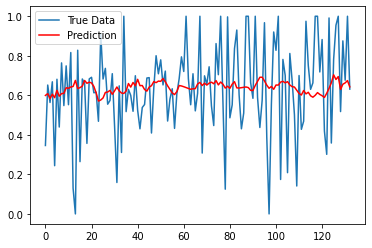

In [49]:
plot_results(y_pred,y_test)

In [50]:
y_pred_noscaled = scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

In [51]:
y_test_unscaled

array([[-0.02406728],
       [ 0.00770671],
       [-0.00145354],
       [ 0.00940861],
       [-0.03468993],
       [ 0.01075299],
       [-0.01435888],
       [ 0.01934931],
       [-0.00308685],
       [ 0.01778416],
       [-0.0026205 ],
       [ 0.02479792],
       [-0.04648519],
       [-0.06003441],
       [ 0.0260129 ],
       [-0.03255767],
       [ 0.01089328],
       [ 0.00867772],
       [-0.02295565],
       [ 0.01093913],
       [ 0.01179319],
       [ 0.00364465],
       [ 0.00396696],
       [-0.0113396 ],
       [ 0.03458817],
       [ 0.01087087],
       [ 0.01648151],
       [-0.00236084],
       [-0.00040186],
       [ 0.01368347],
       [-0.01406842],
       [-0.04351785],
       [ 0.00728332],
       [-0.02773365],
       [ 0.04387689],
       [-0.00625925],
       [ 0.00542425],
       [ 0.00228357],
       [-0.00608987],
       [ 0.01260452],
       [-0.00554652],
       [-0.01530346],
       [-0.00409343],
       [-0.00251986],
       [ 0.01139883],
       [ 0

In [52]:
y_pred_noscaled

array([[ 0.00225141],
       [ 0.00317946],
       [ 0.00063721],
       [ 0.00292093],
       [ 0.00108156],
       [ 0.00491256],
       [ 0.00184238],
       [ 0.00323711],
       [ 0.00330601],
       [ 0.00629264],
       [ 0.0059994 ],
       [ 0.00668737],
       [ 0.00695104],
       [ 0.01015894],
       [ 0.00587073],
       [ 0.00635091],
       [ 0.00715567],
       [ 0.01011521],
       [ 0.00863548],
       [ 0.00921298],
       [ 0.00880992],
       [ 0.00698143],
       [ 0.00358929],
       [-0.00072075],
       [-0.00014465],
       [ 0.00093522],
       [ 0.00383528],
       [ 0.00403938],
       [ 0.00489967],
       [ 0.00284964],
       [ 0.00466051],
       [ 0.00668957],
       [ 0.00465584],
       [ 0.00351258],
       [ 0.00329566],
       [ 0.00455993],
       [ 0.00850938],
       [ 0.00662761],
       [ 0.00905729],
       [ 0.00732508],
       [ 0.01071934],
       [ 0.00738201],
       [ 0.0074646 ],
       [ 0.00538481],
       [ 0.0045066 ],
       [ 0

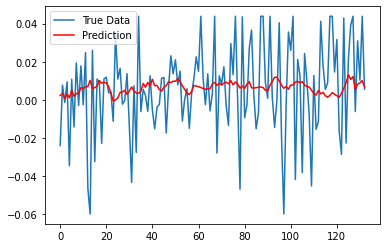

In [53]:
plot_results(y_pred_noscaled,y_test_unscaled)

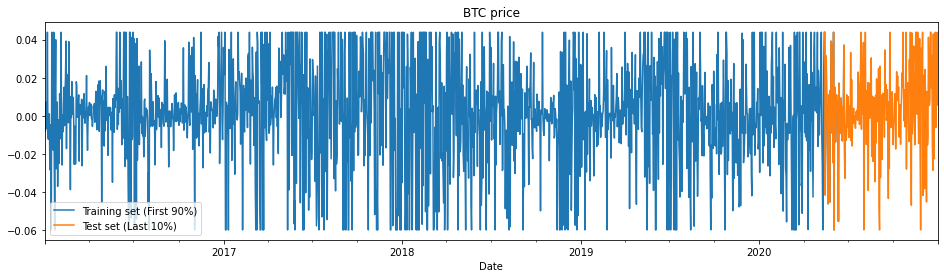

In [54]:
df["BTC"].iloc[0:train_data_len].plot(figsize=(16,4),legend=True)
df["BTC"].iloc[train_data_len - n_past:].plot(figsize=(16,4),legend=True) # 10% is used for thraining data which is approx 2017 data
plt.legend(['Training set (First 90%)','Test set (Last 10%)'])
plt.title('BTC price')
plt.show()

In [55]:
df.head()

,ETH,BTC,XRP,LTC,XLM,Palladium,Gold,HSI,N225,SP500,NVIDIA,AMD
Date,,,,,,,,,,,,
2016-01-02,-0.011498,-0.002049,0.018472,-0.002849,-0.004005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-03,0.037115,-0.007913,-0.007914,-0.005714,0.001723,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-04,-0.017929,0.007163,-0.009806,0.005747,0.002294,-0.023911,0.008379,-0.015704,-0.015203,-0.012430,-0.017900,-0.034843
2016-01-05,-0.004509,-0.002609,0.014434,-0.008571,-0.015446,-0.015527,0.002976,-0.006489,-0.004172,0.001294,0.016064,-0.007220
2016-01-06,0.000720,-0.006598,-0.006784,-0.005764,-0.028472,-0.023911,0.008379,-0.009812,-0.009942,-0.012430,-0.036179,-0.044248


In [56]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 12)            1200      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 12)            1200      
_________________________________________________________________
flatten_1 (Flatten)          (None, 600)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4808      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 7,249
Trainable params: 7,249
Non-trainable params: 0
____________________________________________________

In [57]:
import shap

In [58]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [59]:
x_test[1]

array([[0.41599296, 0.53965698, 0.53881636, 0.51706676, 0.45656785,
        0.55361367, 0.57788437, 0.96706992, 0.87165943, 0.58908631,
        0.58135872, 0.56380863],
       [0.64368948, 0.6256036 , 0.6515989 , 0.71899166, 0.61361248,
        0.55361367, 0.57788437, 0.5929632 , 0.59024655, 0.58908631,
        0.58135872, 0.56380863],
       [0.49207585, 0.51604813, 0.53639844, 0.48472611, 0.49715808,
        0.55361367, 0.57788437, 0.5929632 , 0.59024655, 0.15729059,
        0.58135872, 0.56380863],
       [0.94384114, 0.89754182, 1.        , 0.981198  , 0.97799386,
        0.85029755, 0.67638611, 1.        , 1.        , 0.58908631,
        0.96084095, 0.82186365],
       [0.46573282, 0.45129644, 0.42249206, 0.45996318, 0.67594893,
        0.545312  , 1.        , 0.07187246, 0.41974769, 0.48956879,
        0.63443641, 0.45165928],
       [0.7476721 , 0.76086192, 1.        , 0.88371486, 1.        ,
        0.39582539, 0.87570726, 0.81611887, 0.28802249, 0.99706013,
        1.        ,

In [60]:
x_test[1:2]

array([[[0.41599296, 0.53965698, 0.53881636, 0.51706676, 0.45656785,
         0.55361367, 0.57788437, 0.96706992, 0.87165943, 0.58908631,
         0.58135872, 0.56380863],
        [0.64368948, 0.6256036 , 0.6515989 , 0.71899166, 0.61361248,
         0.55361367, 0.57788437, 0.5929632 , 0.59024655, 0.58908631,
         0.58135872, 0.56380863],
        [0.49207585, 0.51604813, 0.53639844, 0.48472611, 0.49715808,
         0.55361367, 0.57788437, 0.5929632 , 0.59024655, 0.15729059,
         0.58135872, 0.56380863],
        [0.94384114, 0.89754182, 1.        , 0.981198  , 0.97799386,
         0.85029755, 0.67638611, 1.        , 1.        , 0.58908631,
         0.96084095, 0.82186365],
        [0.46573282, 0.45129644, 0.42249206, 0.45996318, 0.67594893,
         0.545312  , 1.        , 0.07187246, 0.41974769, 0.48956879,
         0.63443641, 0.45165928],
        [0.7476721 , 0.76086192, 1.        , 0.88371486, 1.        ,
         0.39582539, 0.87570726, 0.81611887, 0.28802249, 0.99706013,
  

In [61]:
# Use the training data for deep explainer => can use fewer instances
explainer = shap.DeepExplainer(model, x_train)
# explain the the testing instances (can use fewer instanaces)
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(x_test[1:2])
# init the JS visualization code
shap.initjs()

keras is no longer supported, please use tf.keras instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [62]:
shap_values

[array([[[-1.06101270e-03,  1.89072938e-03, -2.63179678e-04,
           1.76905973e-05, -1.74646387e-04, -1.23410231e-04,
           2.33902029e-05, -5.50737509e-03,  5.49213815e-03,
           2.58065565e-05,  1.45726165e-04, -3.04231094e-04],
         [-1.66010235e-05, -8.50756765e-04,  1.18886015e-03,
           7.67365756e-05,  6.60005510e-05, -1.27339280e-04,
           6.37910628e-05, -5.04512321e-05,  1.47664824e-04,
           2.20566736e-05,  5.05833059e-05, -1.16755129e-04],
         [ 7.20464908e-05,  2.35122651e-04,  2.49939644e-05,
           6.40231886e-05,  1.52405583e-04, -5.75907832e-05,
           3.59460197e-05, -7.55158956e-06,  9.38541558e-05,
           1.73884225e-03,  1.24490670e-05, -6.37265975e-07],
         [-1.33785189e-03,  8.24065970e-04, -7.38772404e-04,
          -1.78108805e-03, -1.12549687e-03,  1.72446637e-03,
          -1.46351422e-04,  2.60024744e-03,  1.87053978e-03,
          -2.59503315e-05, -4.45099780e-05, -1.14219742e-03],
         [ 6.5803862

In [63]:
explainer.expected_value

array([0.64307714], dtype=float32)

In [64]:
y_test[1:2]

array([0.65191295])

In [65]:
y_pred[1:2]

array([[0.6083445]], dtype=float32)

In [66]:
len(shap_values)

1

In [67]:
x_test.shape

(133, 50, 12)

In [68]:
shap_values[0].shape

(1, 50, 12)

In [69]:
shap_values[0][0].shape

(50, 12)

In [70]:
features = list(df.columns)

In [71]:
features

['ETH',
 'BTC',
 'XRP',
 'LTC',
 'XLM',
 'Palladium',
 'Gold',
 'HSI',
 'N225',
 'SP500',
 'NVIDIA',
 'AMD']

In [72]:
i=0
j=0

In [73]:
#shap_values[0][i][j]

In [74]:
#x_test[i][j].shape

In [75]:
explainer.expected_value[0], shap_values[0][i][j]

(0.64307714,
 array([-1.06101270e-03,  1.89072938e-03, -2.63179678e-04,  1.76905973e-05,
        -1.74646387e-04, -1.23410231e-04,  2.33902029e-05, -5.50737509e-03,
         5.49213815e-03,  2.58065565e-05,  1.45726165e-04, -3.04231094e-04]))

In [76]:
x_test_df = pd.DataFrame(data=x_test[i][j].reshape(1,12), columns = features)

In [77]:
x_test_df

,ETH,BTC,XRP,LTC,XLM,Palladium,Gold,HSI,N225,SP500,NVIDIA,AMD
0,0.483397,0.468333,0.590553,0.529589,0.551122,0.516438,0.863745,1.0,0.632772,1.0,0.720045,0.505648


In [78]:
shap_values[0]

array([[[-1.06101270e-03,  1.89072938e-03, -2.63179678e-04,
          1.76905973e-05, -1.74646387e-04, -1.23410231e-04,
          2.33902029e-05, -5.50737509e-03,  5.49213815e-03,
          2.58065565e-05,  1.45726165e-04, -3.04231094e-04],
        [-1.66010235e-05, -8.50756765e-04,  1.18886015e-03,
          7.67365756e-05,  6.60005510e-05, -1.27339280e-04,
          6.37910628e-05, -5.04512321e-05,  1.47664824e-04,
          2.20566736e-05,  5.05833059e-05, -1.16755129e-04],
        [ 7.20464908e-05,  2.35122651e-04,  2.49939644e-05,
          6.40231886e-05,  1.52405583e-04, -5.75907832e-05,
          3.59460197e-05, -7.55158956e-06,  9.38541558e-05,
          1.73884225e-03,  1.24490670e-05, -6.37265975e-07],
        [-1.33785189e-03,  8.24065970e-04, -7.38772404e-04,
         -1.78108805e-03, -1.12549687e-03,  1.72446637e-03,
         -1.46351422e-04,  2.60024744e-03,  1.87053978e-03,
         -2.59503315e-05, -4.45099780e-05, -1.14219742e-03],
        [ 6.58038622e-04, -7.2432733

In [79]:
# shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)
i = 0
j = 0
x_test_df = pd.DataFrame(data=x_test[i][j].reshape(1,12), columns = features)
shap.force_plot(explainer.expected_value[0], shap_values[0][i][j], x_test_df)

In [80]:
#devo guardare y_pred e non y_test
y_pred

array([[0.59941334],
       [0.6083445 ],
       [0.58387893],
       [0.60585654],
       [0.58815515],
       [0.6250231 ],
       [0.595477  ],
       [0.6088993 ],
       [0.60956234],
       [0.6383045 ],
       [0.6354825 ],
       [0.6421032 ],
       [0.6446406 ],
       [0.6755122 ],
       [0.6342442 ],
       [0.63886523],
       [0.6466099 ],
       [0.6750914 ],
       [0.660851  ],
       [0.66640866],
       [0.66252977],
       [0.6449331 ],
       [0.61228853],
       [0.5708105 ],
       [0.5763546 ],
       [0.5867469 ],
       [0.61465585],
       [0.61662006],
       [0.62489915],
       [0.6051704 ],
       [0.6225975 ],
       [0.6421244 ],
       [0.62255263],
       [0.6115503 ],
       [0.6094628 ],
       [0.6216296 ],
       [0.65963745],
       [0.64152807],
       [0.6649104 ],
       [0.64824027],
       [0.6809053 ],
       [0.6487881 ],
       [0.6495829 ],
       [0.6295679 ],
       [0.62111634],
       [0.641491  ],
       [0.6486519 ],
       [0.669

In [81]:

pred_i = model.predict(x_test[1:2])
sum_shap_i = shap_values[0][0].sum() + explainer.expected_value[0]

pred_i, sum_shap_i

(array([[0.6083445]], dtype=float32), 0.6083445720315483)

In [82]:
shap.__version__

'0.40.0'

In [83]:
#i = 11
#pred_i = model.predict(x_test[i:i+1])
#sum_shap_i = shap_values[0][i].sum() + explainer.expected_value[0]

#pred_i, sum_shap_i

In [84]:
shap_values_2D = shap_values[0].reshape(-1,12)
x_test_2D = x_test[1:2].reshape(-1,12)


shap_values_2D.shape, x_test_2D.shape

((50, 12), (50, 12))

In [85]:
shap_values_2D

array([[-1.06101270e-03,  1.89072938e-03, -2.63179678e-04,
         1.76905973e-05, -1.74646387e-04, -1.23410231e-04,
         2.33902029e-05, -5.50737509e-03,  5.49213815e-03,
         2.58065565e-05,  1.45726165e-04, -3.04231094e-04],
       [-1.66010235e-05, -8.50756765e-04,  1.18886015e-03,
         7.67365756e-05,  6.60005510e-05, -1.27339280e-04,
         6.37910628e-05, -5.04512321e-05,  1.47664824e-04,
         2.20566736e-05,  5.05833059e-05, -1.16755129e-04],
       [ 7.20464908e-05,  2.35122651e-04,  2.49939644e-05,
         6.40231886e-05,  1.52405583e-04, -5.75907832e-05,
         3.59460197e-05, -7.55158956e-06,  9.38541558e-05,
         1.73884225e-03,  1.24490670e-05, -6.37265975e-07],
       [-1.33785189e-03,  8.24065970e-04, -7.38772404e-04,
        -1.78108805e-03, -1.12549687e-03,  1.72446637e-03,
        -1.46351422e-04,  2.60024744e-03,  1.87053978e-03,
        -2.59503315e-05, -4.45099780e-05, -1.14219742e-03],
       [ 6.58038622e-04, -7.24327336e-04,  5.8431482

In [86]:
x_test_2d = pd.DataFrame(data=x_test_2D, columns = features)

In [87]:
x_test

array([[[0.48339669, 0.4683328 , 0.59055306, ..., 1.        ,
         0.72004505, 0.50564777],
        [0.41599296, 0.53965698, 0.53881636, ..., 0.58908631,
         0.58135872, 0.56380863],
        [0.64368948, 0.6256036 , 0.6515989 , ..., 0.58908631,
         0.58135872, 0.56380863],
        ...,
        [0.44158314, 0.37107471, 0.2949515 , ..., 0.86871088,
         0.48204233, 0.44631316],
        [0.25965133, 0.39079205, 0.24308317, ..., 0.31110192,
         0.4211366 , 0.47486689],
        [0.69916377, 0.67603463, 0.64124365, ..., 0.58908631,
         0.58466824, 0.82779539]],

       [[0.41599296, 0.53965698, 0.53881636, ..., 0.58908631,
         0.58135872, 0.56380863],
        [0.64368948, 0.6256036 , 0.6515989 , ..., 0.58908631,
         0.58135872, 0.56380863],
        [0.49207585, 0.51604813, 0.53639844, ..., 0.15729059,
         0.58135872, 0.56380863],
        ...,
        [0.25965133, 0.39079205, 0.24308317, ..., 0.31110192,
         0.4211366 , 0.47486689],
        [0.6

In [88]:
# x_test_2d

In [89]:
#x_test_2d.corr()

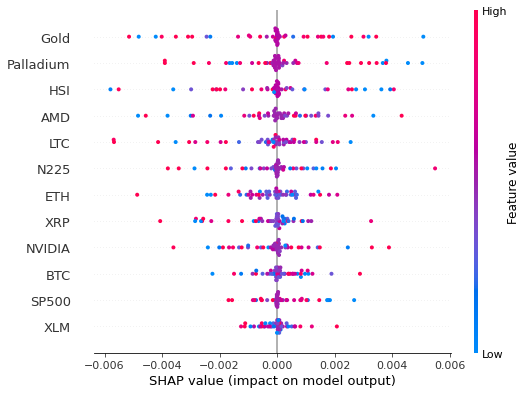

In [90]:
shap.summary_plot(shap_values_2D, x_test_2d)

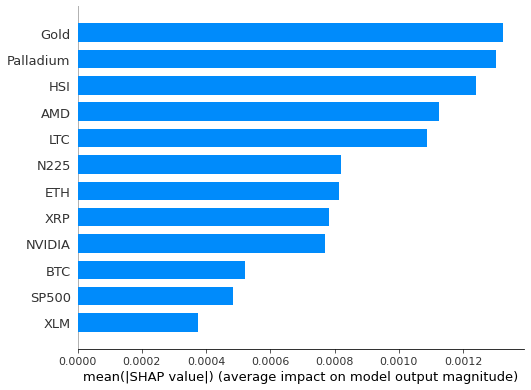

In [91]:
shap.summary_plot(shap_values_2D, x_test_2d, plot_type="bar")

In [92]:
#singola osservazione